# Operational Forecasting Problems

Case study via the [M5 forecasting competition dataset](https://www.kaggle.com/competitions/m5-forecasting-accuracy).

M-competitions named after Spyros Makridakis, [6th edition](https://mofc.unic.ac.cy/the-m6-competition/) ended a few months ago.

M5 data provided by Walmart.



## M5 Data Summary

* 42,840 hierarchical time series, 3049 products (items) from 3 categories, 7 departments
* 3 US states: California (CA), Texas (TX), and Wisconsin (WI), 10 stores
* “Hierarchical” levels: item level, department level, product category level, store level, and state level.
* target: daily sales
* dates: Jan 2011 to June 2016. 
* co-variates: prices, promotions (event), and holidays. 
* no missing values

In [1]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('ggplot')

from gluonts.dataset.common import load_datasets, ListDataset
# from gluonts.dataset.field_names import FieldName
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas

In [2]:
from gluonts.time_feature.holiday import (
        squared_exponential_kernel,
        SpecialDateFeatureSet,
        NEW_YEARS_DAY,
        MARTIN_LUTHER_KING_DAY,
        SUPERBOWL,
        THANKSGIVING,
        CHRISTMAS_EVE,
        CHRISTMAS_DAY,
        NEW_YEARS_EVE
)

# Loading the M5 dataset

Note: the data loading is a little bit involved. The code to load the data set is adapted from 
[Kashif Rasul](https://github.com/zalandoresearch/pytorch-ts/blob/81be06bcc128729ad8901fcf1c722834f176ac34/pts/dataset/repository/_m5.py#L60-L66)

An alternative, straight with pandas is [in this snippet](https://gist.github.com/lostella/8ba1773ce036936eab1d6aadbd3b2b78#file-load_m5_gluonts-py)

In [3]:
# load dates information and sales data
dir_path = Path(os.getcwd()).parent.joinpath("data", "m5-forecasting-accuracy")

calendar = pd.read_csv(dir_path.joinpath("calendar.csv"), parse_dates=["date"])

# fill NaNs with 0 (no event type)
calendar['event_type_1'] = calendar['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
calendar['event_type_2'] = calendar['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)
calendar['snap_CA'] = calendar['snap_CA'].apply(lambda x: 0 if str(x)=="nan" else 1)
calendar['snap_TX'] = calendar['snap_TX'].apply(lambda x: 0 if str(x)=="nan" else 1)
calendar['snap_WI'] = calendar['snap_WI'].apply(lambda x: 0 if str(x)=="nan" else 1)


sales_train_validation = pd.read_csv(
    dir_path.joinpath("sales_train_validation.csv"),
    index_col=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
)

sales_train_validation.sort_index(inplace=True)

sales_train_evaluation = pd.read_csv(
    dir_path.joinpath("sales_train_evaluation.csv"),
    index_col=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
)

sales_train_evaluation.sort_index(inplace=True)

sell_prices = pd.read_csv(
    dir_path.joinpath("sell_prices.csv"),
    index_col=["item_id", "store_id"]
)


sell_prices = sell_prices.sort_index()

## EDA


In [4]:
print(sales_train_validation.shape)
sales_train_validation.info()

(30490, 1913)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30490 entries, ('FOODS_1_001_CA_1_validation', 'FOODS_1_001', 'FOODS_1', 'FOODS', 'CA_1', 'CA') to ('HOUSEHOLD_2_516_WI_3_validation', 'HOUSEHOLD_2_516', 'HOUSEHOLD_2', 'HOUSEHOLD', 'WI_3', 'WI')
Columns: 1913 entries, d_1 to d_1913
dtypes: int64(1913)
memory usage: 446.6+ MB


In [5]:
sales_train_validation.head()

,,,,,,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,item_id,dept_id,cat_id,store_id,state_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,4,2,0,2,0,0,...,0,2,0,4,1,1,0,1,1,0
FOODS_1_001_CA_2_validation,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,2,0,0,0,1,0,8,0,4,1,...,1,0,14,0,1,1,4,0,0,4
FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1,2,1,1,1,2,0,1,1,1,...,0,0,13,0,0,0,0,0,1,0
FOODS_1_001_CA_4_validation,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0,1,1,1,1,1,0,0,0,0,...,0,0,0,2,0,0,0,1,1,1
FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0,1,1,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0


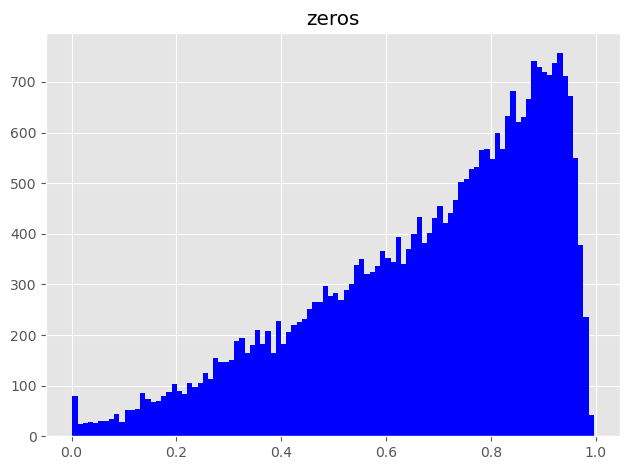

In [7]:
# each row is a time series (with fixed size)
# count zeros on each time series (row) and normalize its size
# most series has many zeros (missing values)
percentage_zeros = (
    sales_train_validation[sales_train_validation == 0]
        .count(axis=1) / len(sales_train_validation.columns)
)
(
    pd.DataFrame(percentage_zeros,columns=['zeros'])
        .hist(bins=100, color="blue")
)
plt.tight_layout()
plt.show()

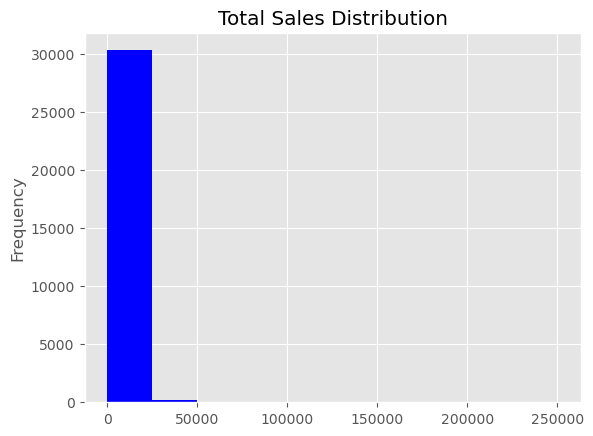

In [8]:
total_sales_by_item = sales_train_validation.sum(axis=1)
(
    pd.DataFrame(total_sales_by_item, columns=['total_sales'])
        .plot(kind="hist", title="Total Sales Distribution", color="blue", legend=None)
)
plt.show()

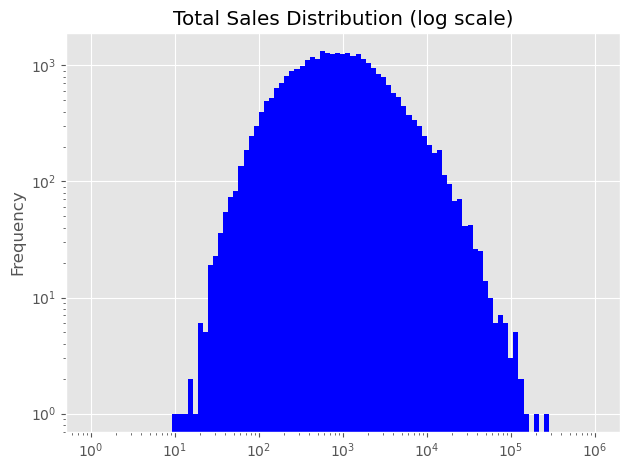

In [9]:
# np.logspace(0, 6, 100) - 100 numbers spaced evenly on a log scale (from 1e0 to 1e6)
(
    pd.DataFrame(total_sales_by_item, columns=['total_sales'])
        .plot(kind="hist", logy=True, logx=True, bins=np.logspace(0, 6, 100),
              title="Total Sales Distribution (log scale)", legend=None, color="blue")
)
plt.tight_layout()
plt.show()

In [10]:
# get total sales on each day
total_daily_sales = (
    sales_train_validation.sum(axis=0)
        .to_frame(name="sales")
        .set_index(calendar.loc[:len(sales_train_validation.columns)-1, "date"])
)
# set index (date) frequency
print(f"inferred frequency: {total_daily_sales.index.inferred_freq}")
total_daily_sales.index.freq = total_daily_sales.index.inferred_freq

inferred frequency: D


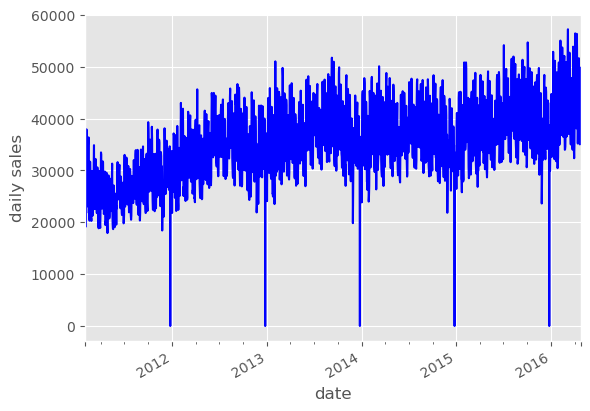

In [11]:
total_daily_sales = (
    sales_train_validation.sum(axis=0)
        .to_frame(name="sales")
        .set_index(calendar.loc[:len(total_daily_sales)-1, "date"])
)
total_daily_sales['sales'].plot(color='blue')
plt.xlabel("date")
plt.ylabel("daily sales")
plt.gcf().autofmt_xdate()

In [12]:
# the day in the year where Walmart is closed
total_daily_sales.loc[total_daily_sales["sales"] < 1000]

,sales
date,
2011-12-25,13
2012-12-25,11
2013-12-25,20
2014-12-25,20
2015-12-25,14


/tmp/ipykernel_125/3688464754.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)
/tmp/ipykernel_125/3688464754.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)


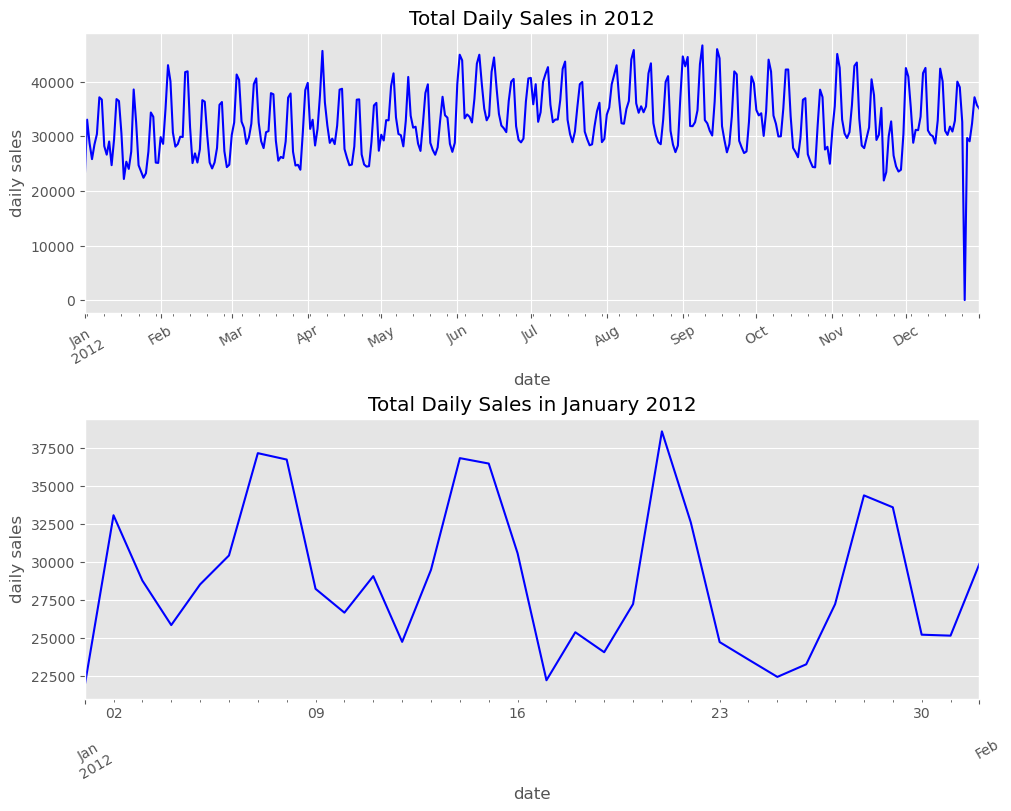

In [13]:
# zooming in
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=1, layout="constrained")
(
    total_daily_sales
        .loc[slice(pd.Timestamp("2012-01-01"), pd.Timestamp("2012-12-31")), 'sales']
        .plot(color="blue", ax=axes[0])
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)
axes[0].set(xlabel="date", ylabel="daily sales", title="Total Daily Sales in 2012")
(
    total_daily_sales
        .loc[slice(pd.Timestamp("2012-01-01"), pd.Timestamp("2012-02-01")), 'sales']
        .plot(color="blue", ax=axes[1])
)
axes[1].set(xlabel="date", ylabel="daily sales", title="Total Daily Sales in January 2012")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)
plt.show()
# plt.suptitle("Total Daily Sales");

## Further data preparation

* look at a subset, FOOD_3, to make things a bit faster
* add further features like additional holidays (there's a Christmas dip!)
* create a training and a test set



In [14]:
# we only look at FOODS_3 to make the data set a bit smaller for demo purposes
sales_train_validation = (
    sales_train_validation
        .xs("FOODS_3", level="dept_id", drop_level=False)
)

sales_train_evaluation = (
    sales_train_evaluation
        .xs("FOODS_3", level="dept_id", drop_level=False)
)

In [15]:
def encode_cat_index(df: pd.DataFrame, idx_level: str|int) -> np.ndarray:
    return pd.CategoricalIndex(df.index.get_level_values(idx_level)).codes

In [16]:
idxes_name = sales_train_validation.index.names[1:]
idxes_name

FrozenList(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

In [17]:
sales_train_validation = sales_train_validation.copy()
sales_train_evaluation = sales_train_evaluation.copy()

In [18]:
# Build static features (order: (state, storre, cat, dept, item))
for idx_name in idxes_name[::-1]:
    idx_col = idx_name.split("_")[0]
    sales_train_validation[idx_col] = encode_cat_index(sales_train_validation, idx_name)
    sales_train_evaluation[idx_col] = encode_cat_index(sales_train_evaluation, idx_name)

## Holidays and Special Events
* represent hoidays and special events with squared exponential kernel

In [19]:
# Add holidays and special events (superbowl, new_years_eve) features
hdays = [
          NEW_YEARS_DAY,
          MARTIN_LUTHER_KING_DAY,
          SUPERBOWL,
          THANKSGIVING,
          CHRISTMAS_EVE,
          CHRISTMAS_DAY,
          NEW_YEARS_EVE]
hdays_name = [
    ' '.join([s.capitalize() for s in hday.split("_")])
    for hday in hdays]
kernel = squared_exponential_kernel(alpha=1.0)

sfs = SpecialDateFeatureSet(hdays, kernel)

date_indices = pd.date_range(
     start=calendar.loc[0, "date"],
     periods=1969,
     freq='1D')

holiday_features = list(sfs(date_indices))

In [20]:
pd.DataFrame(holiday_features[3], index=date_indices, columns=[hdays_name[3]])[hdays_name[3]].value_counts()

0.000000e+00    1924
1.125352e-07      10
1.234098e-04      10
1.831564e-02      10
3.678794e-01      10
1.000000e+00       5
Name: Thanksgiving, dtype: int64

In [21]:
(
    pd.DataFrame(holiday_features[3], index=date_indices, columns=[hdays_name[3]])
        [lambda row: row[hdays_name[3]] == 1]
)

,Thanksgiving
2011-11-24,1.0
2012-11-22,1.0
2013-11-28,1.0
2014-11-27,1.0
2015-11-26,1.0


### Thanksgiving Holiday
* squared exponential kernel- a smoothed indicator:
    * 1 in Thanksgiving
    * increasing/decreasing as we getting closer/far from the holiday
    * 0 o.w.

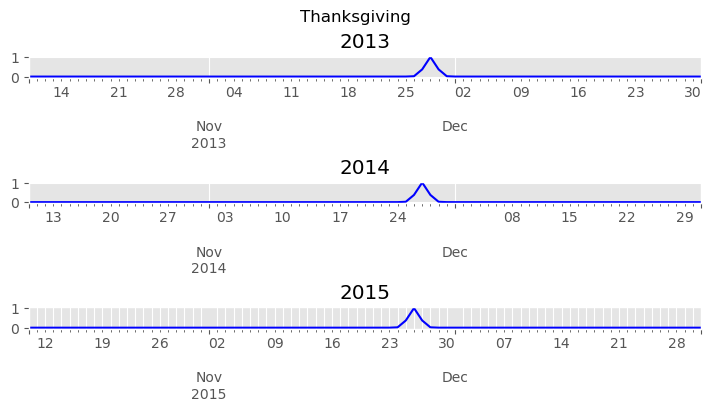

In [22]:
# let's look at a holiday indicator feature (ThanksGiving)
holiday_df = pd.DataFrame(holiday_features[3], index=date_indices, columns=[hdays_name[3]])

fig, axes = plt.subplots(3, 1, figsize=(7, 4), layout="constrained")

holiday_df['2013-10-10':'2013-12-31'].plot(ax=axes[0], legend=False, color="blue", title="2013")
holiday_df['2014-10-10':'2014-12-31'].plot(ax=axes[1], legend=False, color="blue", title="2014")
holiday_df['2015-10-10':'2015-12-31'].plot(ax=axes[2], legend=False, color="blue", title="2015")
fig.suptitle(hdays_name[3])
plt.grid(which="both")

### Static and Dynamic Features
* static features- features available only at train time
    * not available at test time
* dynamic features- time series across train and test

In [23]:
# prepare the categorical features
feat_static_cat = [
        {
            "name": "state_id",
            "cardinality": sales_train_validation["state"].nunique(),
        },
        {
            "name": "store_id",
            "cardinality": sales_train_validation["store"].nunique(),
        },
        {
            "name": "cat_id",
            "cardinality": sales_train_validation["cat"].nunique()
        },
        {
            "name": "dept_id",
            "cardinality": sales_train_validation["dept"].nunique(),
        },
        {
            "name": "item_id",
            "cardinality": sales_train_validation["item"].nunique(),
        },
    ]

feat_dynamic_real = [
        {"name": "sell_price", "cardinality": 1},
        {"name": "event_1", "cardinality": 1},
        {"name": "event_2", "cardinality": 1},
        {"name": "snap", "cardinality": 1},
    ] + [
        {'name': hol, 'cardinality': 1} for hol in sfs.feature_names
    ]

In [24]:
pd.DataFrame(feat_dynamic_real)

,name,cardinality
0,sell_price,1
1,event_1,1
2,event_2,1
3,snap,1
4,new_years_day,1
5,martin_luther_king_day,1
6,superbowl,1
7,thanksgiving,1
8,christmas_eve,1
9,christmas_day,1


In [25]:
pd.DataFrame(feat_static_cat)

,name,cardinality
0,state_id,3
1,store_id,10
2,cat_id,1
3,dept_id,1
4,item_id,823


In [26]:
stat_cat_cardinalities = pd.DataFrame(feat_static_cat)["cardinality"].to_list()
stat_cat_cardinalities

[3, 10, 1, 1, 823]

In [27]:
from functools import lru_cache

@lru_cache(maxsize=None)
def get_sell_price(item_id, store_id, func=None):
    prices = (
        calendar
            .merge(sell_prices.loc[item_id, store_id], on=["wm_yr_wk"], how="left")
            .sell_price)
    if (func=='diff'):
        return np.diff(prices)
    elif (func=='rel'):
        return prices[:-1]/prices[0]
    return prices

## Training set
* time_series dictionary
    * `start`: str- start date
    * `item_id`: str- id
    * `feat_static_cat`: np.ndarray (cat_size,) - list of categorical (encoding) values
        * encoding the hierarchy attributes (state, store, cat, dept, item)
    * `target`: np.ndarray (ts_size,) - time series values (starting from first nonzero values)
        * train+test period
    * `feat_dynamic_real`: (dynamic_size, ts_size)- list of features, where each feature is a time series (same size as target)
        * features that vary over time
        * train+test period (available on test time)

In [28]:
# Build training set
train_ds = []
for index, item in sales_train_validation.iterrows():
    id_, item_id, dept_id, cat_id, store_id, state_id = index
    start_index = (item > 0 ).argmax()
    start_date = calendar.loc[start_index, "date"]
    time_series = {}

    # start-  start date (string) and id
    time_series["start"] = str(start_date)
    time_series["item_id"] = id_[:-11]  # remove 'validation'/'evaluation' suffix
    # static features: state_enc, store_enc, cat_enc, dept_enc, item_enc
    time_series["feat_static_cat"] = item.iloc[1913:].to_numpy()
    sell_price = get_sell_price(item_id, store_id)
    # target- time series values
    time_series["target"] = (
            item.iloc[start_index:1913].values.astype(np.float32)
    )
    # feat_dynamic_real - sells, events, holidays
    time_series["feat_dynamic_real"] = (
        np.concatenate(
                (
                    np.expand_dims(sell_price.iloc[start_index:1913].values, 0),
                    np.expand_dims(calendar['event_type_1'].iloc[start_index:1913].values, 0),
                    np.expand_dims(calendar['event_type_2'].iloc[start_index:1913].values, 0),
                    np.expand_dims(calendar['snap_'+state_id].iloc[start_index:1913].values, 0),
                    np.expand_dims(holiday_features[0][start_index:1913], 0),
                    np.expand_dims(holiday_features[1][start_index:1913], 0),
                    np.expand_dims(holiday_features[2][start_index:1913], 0),
                    np.expand_dims(holiday_features[3][start_index:1913], 0),
                    np.expand_dims(holiday_features[4][start_index:1913], 0),
                    np.expand_dims(holiday_features[5][start_index:1913], 0),
                    np.expand_dims(holiday_features[6][start_index:1913], 0)

                ),
                0,
            )
        .astype(np.float32)  # (n_dynamic_feat, time_series_length)
    )

    train_ds.append(time_series)

In [29]:
train_ds = ListDataset(train_ds, freq='1D')

In [30]:
#  plot price vs demand for a fast-moving item with price changes (more than 5 changes)
fast_moving_ts = [s for s in train_ds if s['target'].sum() > 5000 and len(np.unique(s['feat_dynamic_real'][0])) > 5][0]

fast_moving_df = pd.DataFrame(
    data=np.concatenate([fast_moving_ts["target"][None, :], fast_moving_ts['feat_dynamic_real'][[0, 1, 3], :]], axis=0).T,
    columns=['target','price','event','snap'],
    index=date_indices[:len(fast_moving_ts["target"])]
)

In [31]:
fast_moving_df.head()

,target,price,event,snap
2011-01-29,7.0,0.2,0.0,1.0
2011-01-30,32.0,0.2,0.0,1.0
2011-01-31,3.0,0.2,0.0,1.0
2011-02-01,2.0,0.2,0.0,1.0
2011-02-02,0.0,0.2,0.0,1.0


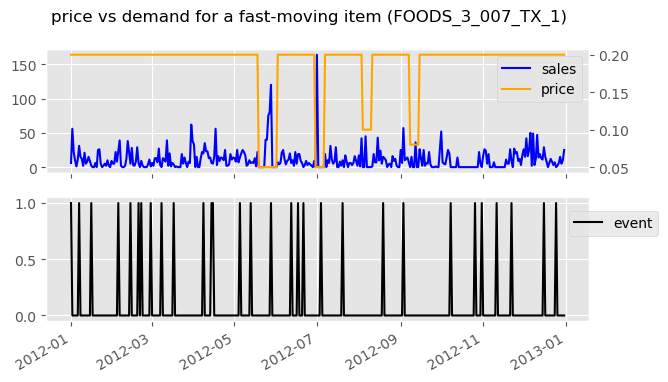

In [32]:
# Sales (blue) vs price changes (orange) vs events (black)
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax2 = ax[0].twinx()
# ax3 = ax[1].twinx()

ax[0].plot(fast_moving_df.loc['2012', 'target'], color='blue', label="sales")
ax2.plot(fast_moving_df.loc['2012', 'price'], color='orange', label="price")
handles = [
    Line2D([], [], color="blue", label="sales"),
    Line2D([], [], color="orange", label="price")
]
ax[0].legend(handles=handles, frameon=True);
ax[1].plot(fast_moving_df.loc['2012', 'event'], color='black', label="event")
ax[1].legend(bbox_to_anchor=(0.95, 0.95))
plt.grid(which="both")
fig.autofmt_xdate()
plt.suptitle(f"price vs demand for a fast-moving item ({fast_moving_ts['item_id']})");

In [33]:
# Build testing set
test_ds = []
for index, item in sales_train_evaluation.iterrows():
    id_, item_id, dept_id, cat_id, store_id, state_id = index
    start_index = (item > 0 ).argmax()
    start_date = calendar.loc[start_index, "date"]
    time_series = {}

    time_series["start"] = str(start_date)
    time_series["item_id"] = id_[:-11]  # remove 'validation'/'evaluation' suffix
    # static features: state_enc, store_enc, cat_enc, dept_enc, item_enc
    time_series["feat_static_cat"] = item.iloc[1941:].to_numpy()
    sell_price = get_sell_price(item_id, store_id)
    # target- time series values
    time_series["target"] = (
        item.iloc[start_index:1941].values.astype(np.float32)
        )
    time_series["feat_dynamic_real"] = (
        np.concatenate(
                (
                    np.expand_dims(sell_price.iloc[start_index:1941].values, 0),
                    np.expand_dims(calendar['event_type_1'].iloc[start_index:1941].values, 0),
                    np.expand_dims(calendar['event_type_2'].iloc[start_index:1941].values, 0),
                    np.expand_dims(calendar['snap_'+state_id].iloc[start_index:1941].values, 0),
                    np.expand_dims(holiday_features[0][start_index:1941], 0),
                    np.expand_dims(holiday_features[1][start_index:1941], 0),
                    np.expand_dims(holiday_features[2][start_index:1941], 0),
                    np.expand_dims(holiday_features[3][start_index:1941], 0),
                    np.expand_dims(holiday_features[4][start_index:1941], 0),
                    np.expand_dims(holiday_features[5][start_index:1941], 0),
                    np.expand_dims(holiday_features[6][start_index:1941], 0)

                ),
                0,
        )
        .astype(np.float32)
    )

    test_ds.append(time_series)

## Transformed data

Let's look at the data that we've created now before we pass it to the models.

In [34]:
# # sanity check if we can read in the data
test_ds = ListDataset(test_ds, freq='1D')
next(iter(test_ds))

{'start': Period('2011-01-29', 'D'),
 'item_id': 'FOODS_3_001_CA_1',
 'feat_static_cat': array([0, 0, 0, 0, 0], dtype=int32),
 'target': array([1., 1., 1., ..., 0., 0., 2.], dtype=float32),
 'feat_dynamic_real': array([[2.28, 2.28, 2.28, ..., 2.5 , 2.5 , 2.5 ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)}

# Baseline: NPTS

* NPTS = Non-parametric time series forecaster
* reference: [page 11 from GluonTS JMLR paper](https://arxiv.org/pdf/1906.05264.pdf)
* A generalization of the climatological forecaster:
    * climatological forecaster samples every past value with equal probability
    * NPTS allows to adjust this uniform distribution, e.g., using an exponential decay => values in the near past are exponentially more likely to be sampled
    * kernel function can be made seasonal

In [35]:
from tqdm import tqdm
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.npts import NPTSPredictor
from gluonts.model.forecast import SampleForecast
from gluonts.evaluation import Evaluator

In [36]:
# make forecast on the last prediction_length dates
prediction_length = 28

A useful tool in GluonTS is the ``make_evaluation_predictions`` short cut that helps to get forecasts on the last available part of the data set provided. There are other useful tools around [data splitting](https://ts.gluon.ai/stable/tutorials/data_manipulation/dataset_splitting_example.html).

In [37]:
# use_seasonal_model = True - use a seasonal variant
# kernel_type=exponential kernel (less weight to far examples)
# exp_kernel_weights=1.0 - the weights for the features to use in the exp. kernel
npts = NPTSPredictor(freq="1D", prediction_length=prediction_length)

In [38]:
# a GluonTS short-hand to make forecasts in a backtest scenario
forecast_npts_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=npts,
    num_samples=100
)
# list of pandas time series (index=date, data=target)
tss = list(tqdm(ts_it, total=len(test_ds)))
# list of sample forecasts of the last prediction_lenght periods (shape=(num_samples, prediction_length))
forecasts_npts = list(tqdm(forecast_npts_it, total=len(test_ds)))

100%|██████████| 8230/8230 [27:50<00:00,  4.93it/s]


## Let's look at some sparse/intermittent time series

* A sparse or intermittent time series is one with lots of 0s.
* Many forecasting methods struggle with these
* NPTS doesn't -- by design!



In [39]:
def plot_prob_forecasts(ts: pd.DataFrame, forecast_ent: SampleForecast):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7), layout="tight")
    ts[-plot_length:].plot(ax=ax, color='blue')  # plot the time series
    forecast_ent.plot(prediction_intervals=prediction_intervals, color='green')
    plt.legend(legend, loc="upper left")  # , bbox_to_anchor=(0.1, 1))
    plt.grid(which="both")
    fig.autofmt_xdate()

In [40]:
ct = 0
ts_forecast_list = []
for ts, forecast in zip(tss, forecasts_npts):
    if (ts.sum().item() <= 1000.0):  # is sparse
        ts_forecast_list.append([ts, forecast])
        ct += 1
    if ct > 10:
        break

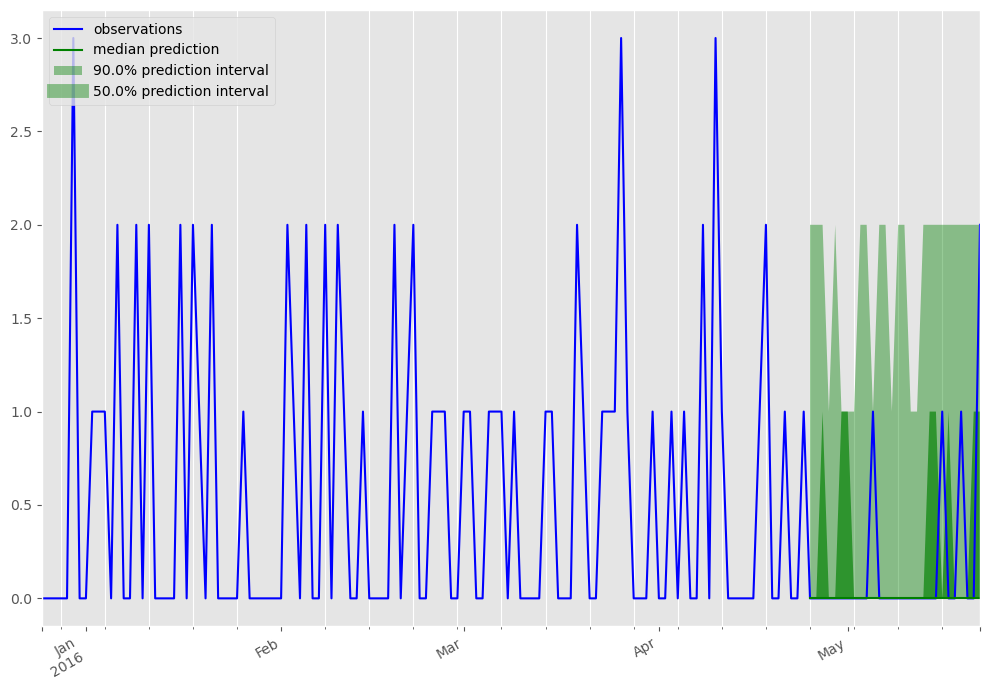

In [41]:
plt_idx = 0
plot_prob_forecasts(*ts_forecast_list[plt_idx])

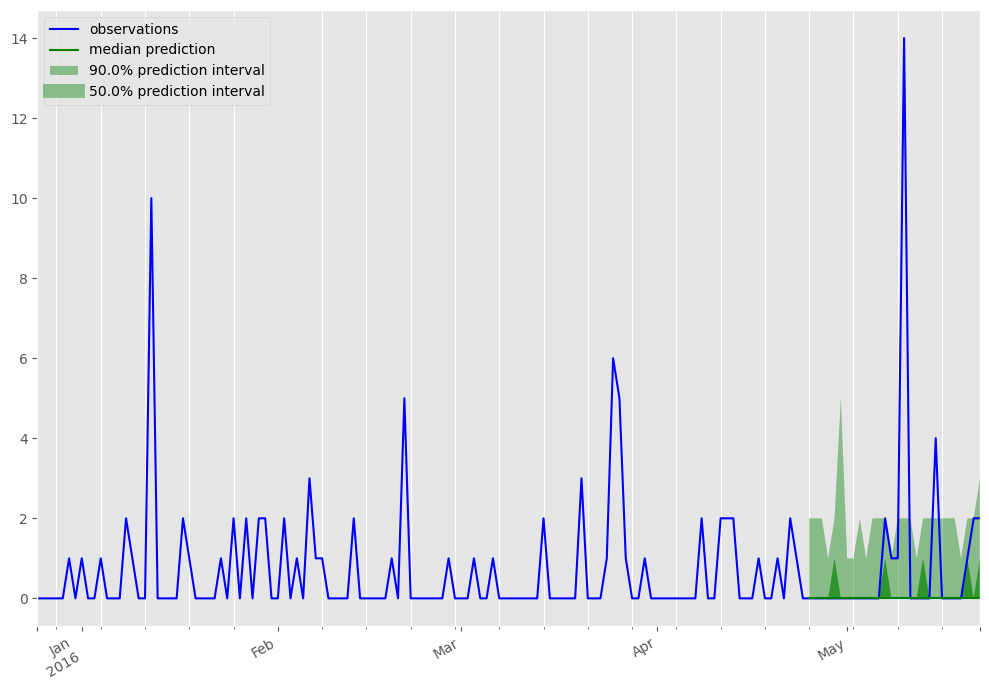

In [42]:
plt_idx = 1
plot_prob_forecasts(*ts_forecast_list[plt_idx])

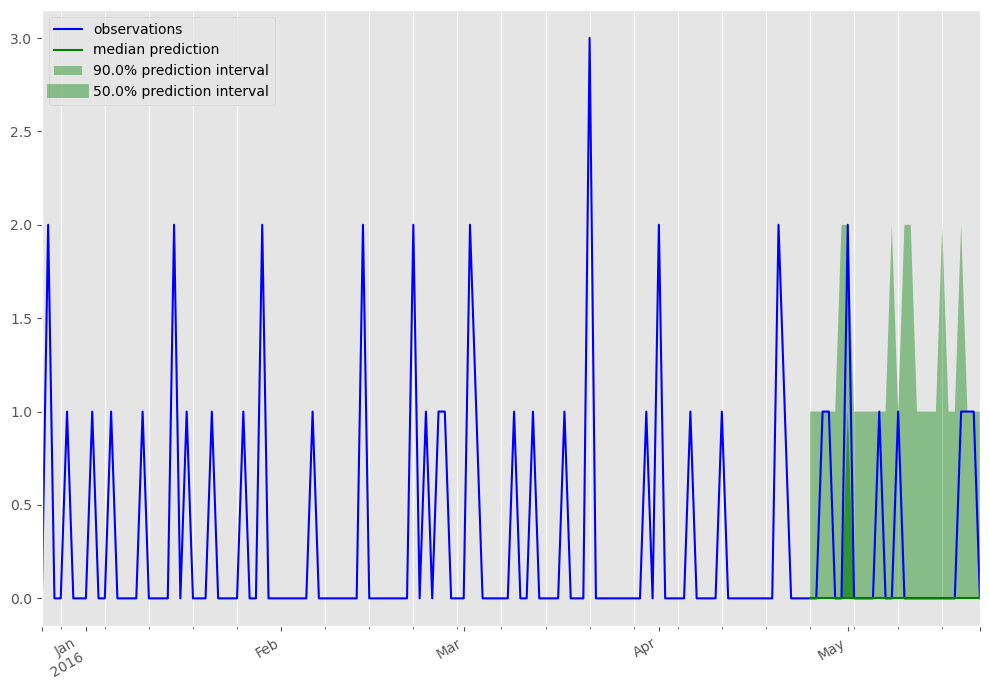

In [43]:
plt_idx = 2
plot_prob_forecasts(*ts_forecast_list[plt_idx])

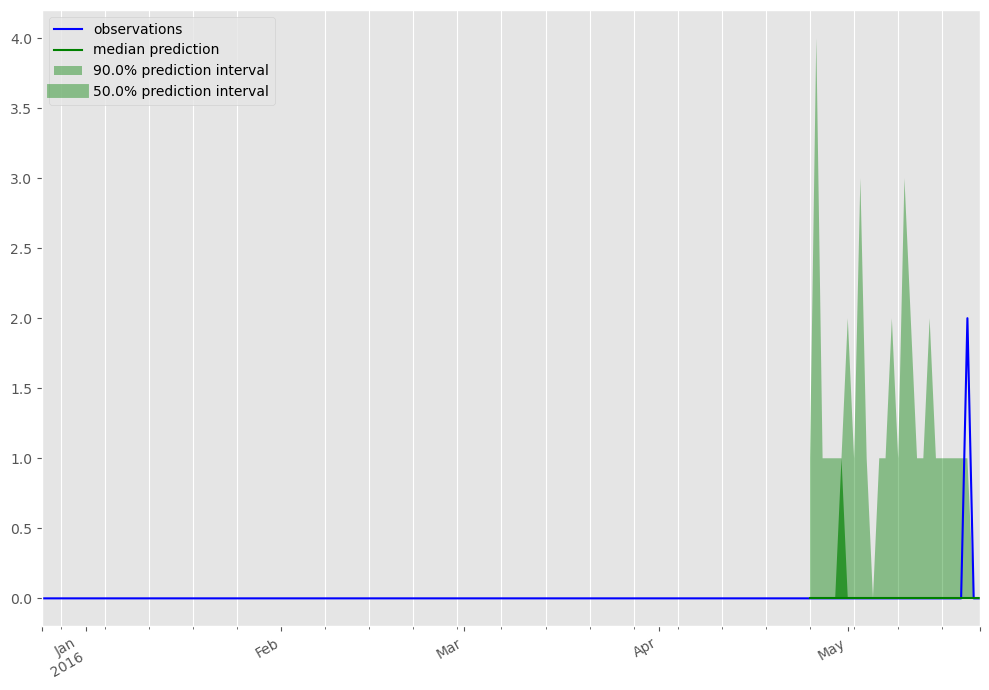

In [44]:
plt_idx = 3
plot_prob_forecasts(*ts_forecast_list[plt_idx])

## Plot aggregate demand vs aggregated forecast

A helpful qualitative diagnostic instrument is plotting the aggregated actuals versus the aggregated forecasts. We probabilistic forecasts in a sample path representation, we can easily produce aggregated probabilistic forecasts - we just sum the sample paths. 

## Global Analysis
* sum up all time series

In [45]:
# helper function to plot the aggregated values against aggregated forecasts
def sum_forecasts(left: SampleForecast, right: SampleForecast) -> SampleForecast:
    return  SampleForecast(
        left.samples + right.samples,
        left.start_date,
        left.item_id,
        left.info
    )

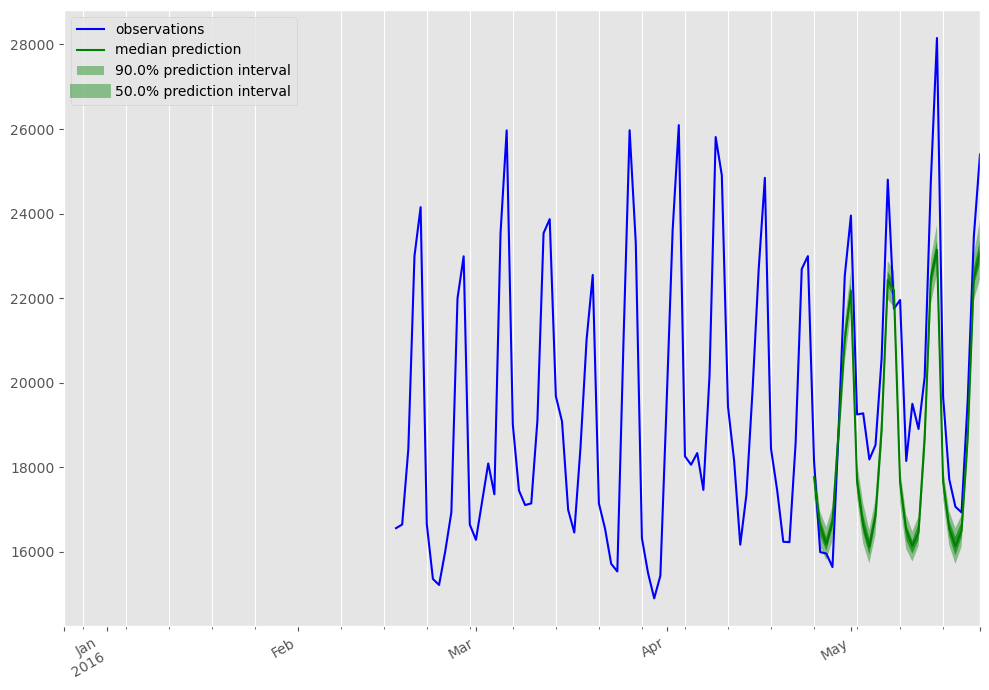

In [46]:
agg_actuals = sum(tss)
# sum all forecastings
agg_prob_forecasts = reduce(lambda a, b: sum_forecasts(a, b), forecasts_npts)

# plot the aggregated sales against the aggregated forecast
plot_prob_forecasts(agg_actuals, agg_prob_forecasts)

In [47]:
# calculate metrics for NPTS
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# outputs metrics both across time series (agg = global) and for individual time series
agg_metrics_npts, item_metrics_npts = evaluator(tss, forecasts_npts)

Running evaluation: 8230it [00:00, 19632.27it/s]
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [48]:
print(json.dumps(agg_metrics_npts, indent=4))

{
    "MSE": 11.459106907654922,
    "abs_error": 366211.0,
    "abs_target_sum": 564926.0,
    "abs_target_mean": 2.4515101544870683,
    "seasonal_error": 1.6637613497420738,
    "MASE": 1.0031456740861684,
    "MAPE": 0.727813549474634,
    "sMAPE": 1.3656307097565348,
    "MSIS": 9.81787077258163,
    "QuantileLoss[0.1]": 115812.6,
    "Coverage[0.1]": 0.4466108314528727,
    "QuantileLoss[0.5]": 366211.0,
    "Coverage[0.5]": 0.6149756986634265,
    "QuantileLoss[0.9]": 239977.2,
    "Coverage[0.9]": 0.8921931956257593,
    "RMSE": 3.385130264503114,
    "NRMSE": 1.3808346901224187,
    "ND": 0.6482459649582423,
    "wQuantileLoss[0.1]": 0.205004903297069,
    "wQuantileLoss[0.5]": 0.6482459649582423,
    "wQuantileLoss[0.9]": 0.4247940438216687,
    "mean_absolute_QuantileLoss": 240666.93333333335,
    "mean_wQuantileLoss": 0.42601497069232663,
    "MAE_Coverage": 0.3973977318752531,
    "OWA": NaN
}


In [49]:
item_metrics_npts.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,FOODS_3_001_CA_1,2016-04-25,0.229671,5.0,5.0,0.178571,0.624477,0.285954,1.000000,2.000000,1.000000,3.431443,1.0,0.857143,5.0,0.857143,5.6,1.000000
1,FOODS_3_001_CA_2,2016-04-25,7.652911,27.0,27.0,0.964286,0.668589,1.442269,1.000000,2.000000,1.000000,31.088908,5.4,0.714286,27.0,0.714286,36.2,0.892857
2,FOODS_3_001_CA_3,2016-04-25,5.349775,60.0,69.0,2.464286,1.246862,1.718600,0.763889,1.462984,0.869565,7.103547,13.8,0.250000,60.0,0.285714,29.0,0.785714
3,FOODS_3_001_CA_4,2016-04-25,0.294093,9.0,9.0,0.321429,0.269009,1.194862,1.000000,2.000000,1.000000,6.239836,1.8,0.714286,9.0,0.714286,9.0,0.892857
4,FOODS_3_001_TX_1,2016-04-25,0.188436,2.0,2.0,0.071429,0.648875,0.110081,1.000000,2.000000,1.000000,3.467540,0.4,0.964286,2.0,0.964286,5.6,0.964286


### Time Series Aggregation by Group Velocity
* group velocity- the overall envelope shape of the wave's amplitudes
    * known as the modulation or envelope of the wave—propagates through space.
    * the area of the envelope- sum of the absolute values of the time series
* small group velocity:
    * many zeros- sparse/intermittent time series
    * small changes relative to zero
* large group velocity:
    * many large values deviate significantly from zero
    * may have small amount of zeros
    * may have large variance

In [50]:
bins = np.linspace(0, item_metrics_npts['abs_target_sum'].max(), 5)
velocity_groups = (
    item_metrics_npts
        .groupby(pd.cut(item_metrics_npts.abs_target_sum, bins), observed=True)
        .mean(numeric_only=True)
)
velocity_groups

,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
abs_target_sum,,,,,,,,,,,,,,,,
"(0.0, 839.25]",8.978844,42.662023,63.429970,2.265356,1.575881,1.019161,0.729783,1.359924,0.987410,9.950130,13.520331,0.433753,42.662023,0.605686,27.728414,0.889652
"(839.25, 1678.5]",382.462063,387.461538,1140.692308,40.739011,12.214685,1.296379,0.417740,0.444245,0.351759,9.876123,153.589744,0.071429,387.461538,0.392857,222.087179,0.820513
"(1678.5, 2517.75]",489.174256,408.833333,1945.333333,69.476190,20.418061,0.711386,0.212458,0.214363,0.211237,6.276124,244.100000,0.107143,408.833333,0.577381,233.800000,0.886905
"(2517.75, 3357.0]",958.463150,759.000000,3357.000000,119.892857,40.722803,0.665650,0.218395,0.235627,0.226095,4.434160,237.400000,0.035714,759.000000,0.357143,440.400000,0.678571


# DeepAR

[DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888) is an RNN-based, probabilistic forecasting method.


In [51]:
from gluonts.torch.model.deepar import DeepAREstimator

In [52]:
estimator_deepar_naive = DeepAREstimator(
    prediction_length=prediction_length,
    freq="1D",
    # lags are determined automatically based on frequency
        # lags_seq = [1], 
    # scaling is automatically enabled, but can we switched off
    # scaling = False, 
    trainer_kwargs={
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "max_epochs": 100,
    },
    num_feat_dynamic_real=len(feat_dynamic_real),
    num_feat_static_cat=len(stat_cat_cardinalities),
    num_feat_static_real=0,
    cardinality=stat_cat_cardinalities,
)


In [53]:
predictor_deepar_naive = estimator_deepar_naive.train(train_ds)

/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Missing logger folder: /home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs

  | Name  | Type        | Params | In sizes                                                           | Out sizes   
----------------------------------------------------

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 1.82642 (best 1.82642), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 1.57535 (best 1.57535), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 1.41321 (best 1.41321), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 1.32609 (best 1.32609), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 1.31600 (best 1.31600), saving model to '/home/studio-l

In [54]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor_deepar_naive,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts_deepar_naive = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


100%|██████████| 8230/8230 [00:01<00:00, 6342.36it/s]


Obtaining time series predictions ...


100%|██████████| 8230/8230 [03:09<00:00, 43.33it/s]


In [55]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# outputs metrics both across time series (agg = global) and for individual time series
agg_metrics_deepar_naive, item_metrics_deepar_naive = evaluator(tss, forecasts_deepar_naive)

Running evaluation: 8230it [00:00, 15411.84it/s]
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [56]:
print(json.dumps(agg_metrics_deepar_naive, indent=4))

{
    "MSE": 11.159875842829788,
    "abs_error": 351198.7506178976,
    "abs_target_sum": 564926.0,
    "abs_target_mean": 2.4515101544870683,
    "seasonal_error": 1.6637613497420738,
    "MASE": 0.9735873622931973,
    "MAPE": 0.7932063148111024,
    "sMAPE": 1.5120702197290592,
    "MSIS": 15.978549146939288,
    "QuantileLoss[0.1]": 114199.9932907047,
    "Coverage[0.1]": 0.006005901753167852,
    "QuantileLoss[0.5]": 351198.75069308485,
    "Coverage[0.5]": 0.25419198055893066,
    "QuantileLoss[0.9]": 281529.05093517056,
    "Coverage[0.9]": 0.6861612567262628,
    "RMSE": 3.34064003490795,
    "NRMSE": 1.3626865990310022,
    "ND": 0.6216721316028959,
    "wQuantileLoss[0.1]": 0.20215035826055927,
    "wQuantileLoss[0.5]": 0.6216721317359881,
    "wQuantileLoss[0.9]": 0.4983467762771948,
    "mean_absolute_QuantileLoss": 248975.9316396534,
    "mean_wQuantileLoss": 0.4407230887579141,
    "MAE_Coverage": 0.3287204189087543,
    "OWA": NaN
}


In [57]:
item_metrics_deepar_naive.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,FOODS_3_001_CA_1,2016-04-25,0.250095,5.013788,5.0,0.178571,0.624477,0.286742,1.000270,2.000000,1.002758,11.434244,1.007168,0.0,5.013788,0.000000,9.000280,0.714286
1,FOODS_3_001_CA_2,2016-04-25,8.107648,27.013046,27.0,0.964286,0.668589,1.442966,1.000177,2.000000,1.000483,57.675531,5.405919,0.0,27.013045,0.000000,48.598411,0.428571
2,FOODS_3_001_CA_3,2016-04-25,7.190319,64.039459,69.0,2.464286,1.246862,1.834304,0.812136,1.611999,0.928108,14.365230,16.748756,0.0,64.039458,0.285714,42.268491,0.714286
3,FOODS_3_001_CA_4,2016-04-25,0.393042,9.007130,9.0,0.321429,0.269009,1.195809,1.000280,2.000000,1.000792,47.779909,1.803255,0.0,9.007129,0.000000,16.200253,0.571429
4,FOODS_3_001_TX_1,2016-04-25,0.142901,2.006685,2.0,0.071429,0.648875,0.110449,1.000124,2.000000,1.003342,4.405144,0.403872,0.0,2.006685,0.000000,3.600765,0.964286


In [58]:
bins = np.linspace(0, item_metrics_deepar_naive['abs_target_sum'].max(),5)
velocity_groups = (
    item_metrics_deepar_naive
        .groupby(pd.cut(item_metrics_deepar_naive.abs_target_sum, bins), observed=True)
        .mean(numeric_only=True)
)
velocity_groups

,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
abs_target_sum,,,,,,,,,,,,,,,,
"(0.0, 839.25]",8.957783,41.790748,63.429970,2.265356,1.575881,0.998888,0.795844,1.505453,0.892063,16.418994,13.354802,0.006073,41.790748,0.259350,33.856475,0.687119
"(839.25, 1678.5]",388.147785,365.461966,1140.692308,40.739011,12.214685,1.196991,0.353899,0.384638,0.326709,15.773599,153.911886,0.019231,365.461965,0.313187,250.437167,0.784799
"(1678.5, 2517.75]",581.907599,506.256017,1945.333333,69.476190,20.418061,0.873612,0.239044,0.269261,0.259890,5.881968,223.866960,0.017857,506.256006,0.297619,253.233564,0.791667
"(2517.75, 3357.0]",1840.124442,898.613220,3357.000000,119.892857,40.722803,0.788092,0.233205,0.273925,0.267683,5.685861,433.410783,0.000000,898.613251,0.214286,436.163680,0.678571


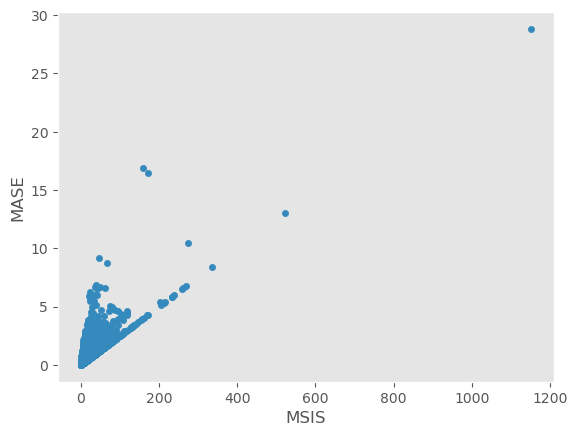

In [59]:
item_metrics_deepar_naive.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

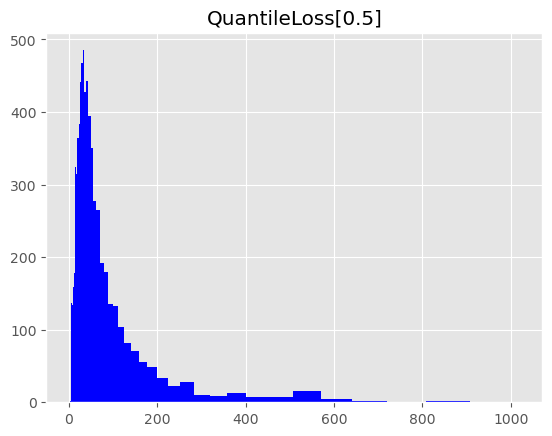

In [60]:
# obtain histogram of errors
# one the right - large errors
metric='QuantileLoss[0.5]'
bins=np.append(
    [0], np.logspace(np.log10(0.01), np.log10(item_metrics_deepar_naive[metric].max()), 100)
    )
item_metrics_deepar_naive.hist(column=metric, bins=bins, color="blue");

In [61]:
# still plot the forecasts num_feat_dynamic_real
# first entry of the time series list
ts_entry = tss[0]

In [62]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [63]:
# first entry of the forecast list
forecast_entry = forecasts_deepar_naive[0]

In [64]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 28)
Start date of the forecast window: 2016-04-25
Frequency of the time series: <Day>


In [65]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [-0.00182443 -0.00070774 -0.0013413  -0.00156013 -0.0008047  -0.0006012
 -0.0004434  -0.00054581 -0.00052644 -0.00060504 -0.00045797 -0.0003327
 -0.00044851 -0.00017877 -0.00029754 -0.00054157 -0.00035421 -0.00037533
 -0.00017388 -0.00033243 -0.00013915 -0.0001441  -0.00034233 -0.00044053
 -0.00021232 -0.00039597 -0.00033675 -0.00025582]
0.5-quantile (median) of the future window:
 [-0.00172307 -0.00074553 -0.00085996 -0.00139366 -0.00068039 -0.00056321
 -0.00054598 -0.00038461 -0.00056142 -0.0006428  -0.00046431 -0.00028687
 -0.00033268 -0.00021922 -0.00025613 -0.00051818 -0.00033593 -0.00030029
 -0.00027698 -0.00034596 -0.00016394 -0.00023395 -0.00039832 -0.00039062
 -0.00024223 -0.0003188  -0.00032646 -0.00027603]


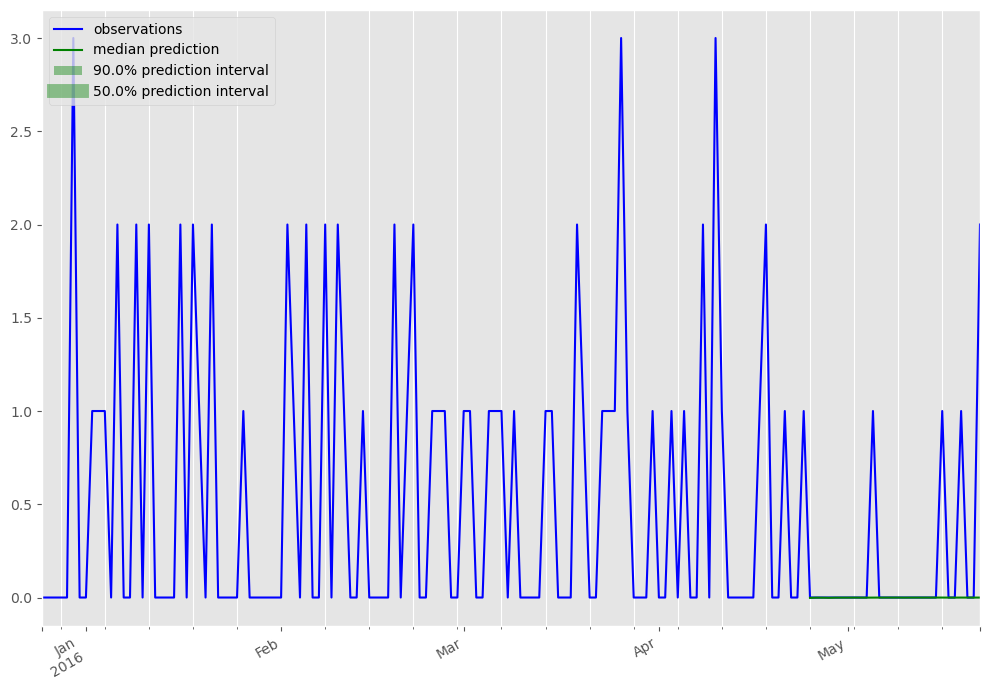

In [66]:
plot_prob_forecasts(tss[0], forecast_entry)

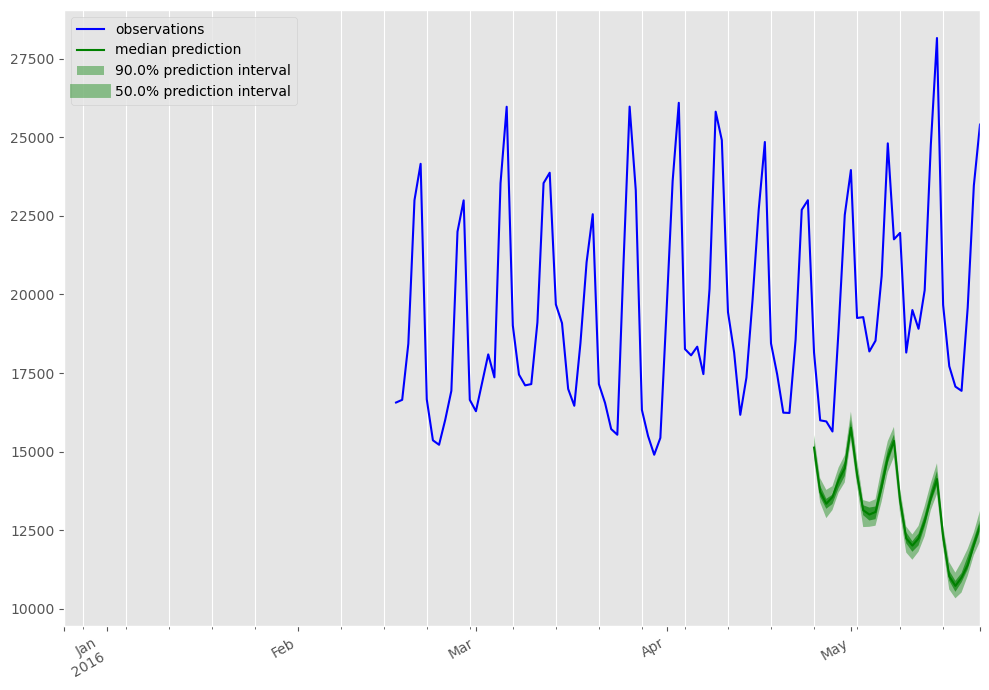

In [67]:
# agg_actuals = sum(tss)
agg_prob_forecasts_deepar = reduce(
    lambda a, b: sum_forecasts(a, b), forecasts_deepar_naive)

# plot the aggregated sales against the aggregated forecast
plot_prob_forecasts(agg_actuals, agg_prob_forecasts_deepar)

## Plot top/bottom k individual time series

Using the metrics by time series, we can easily plot the worst and best time series for an error metric.

In [68]:
k = 3
# worst k (largest MSE)
metric = 'MSE'
item_metrics_deepar_naive.nlargest(k, metric)

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
2328,FOODS_3_234_WI_2,2016-04-25,2619.512277,1020.292603,1089.0,38.892857,22.698745,1.605332,0.887318,1.679589,0.936908,39.408221,245.420496,0.0,1020.292528,0.107143,1349.187394,0.500000
882,FOODS_3_090_CA_3,2016-04-25,1840.124442,898.613220,3357.0,119.892857,40.722803,0.788092,0.233205,0.273925,0.267683,5.685861,433.410783,0.0,898.613251,0.214286,436.163680,0.678571
4428,FOODS_3_444_WI_2,2016-04-25,1612.988979,855.040588,855.0,30.535714,4.654533,6.560736,1.000037,2.000000,1.000047,262.413226,171.013843,0.0,855.040551,0.000000,1539.024477,0.035714


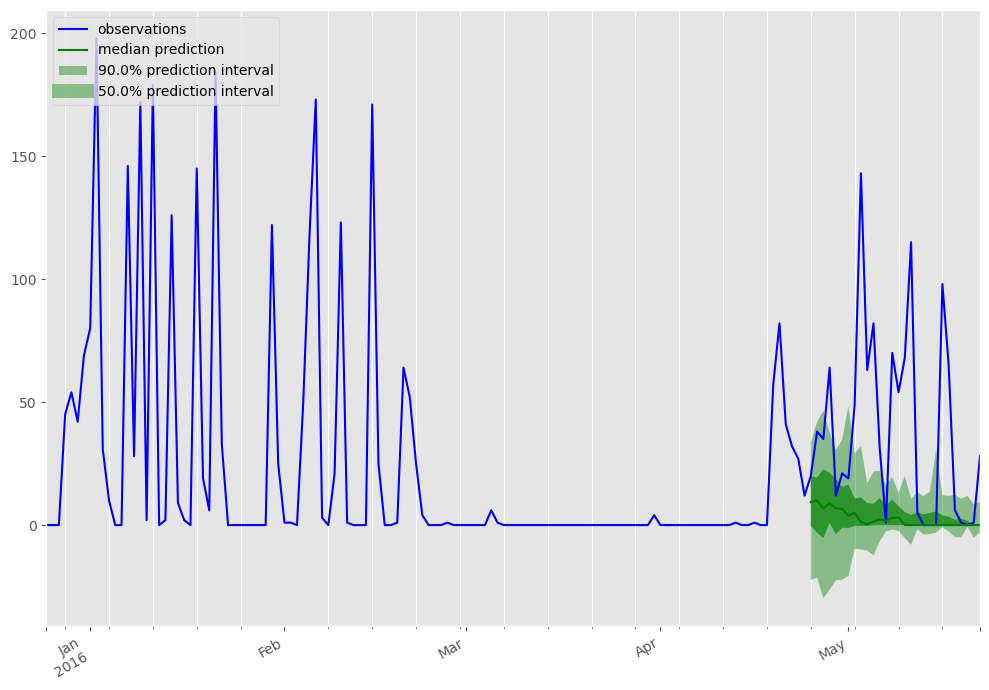

In [69]:
indices = item_metrics_deepar_naive.nlargest(k, metric).index
idx = indices[0]
plot_prob_forecasts(tss[idx], forecasts_deepar_naive[idx])

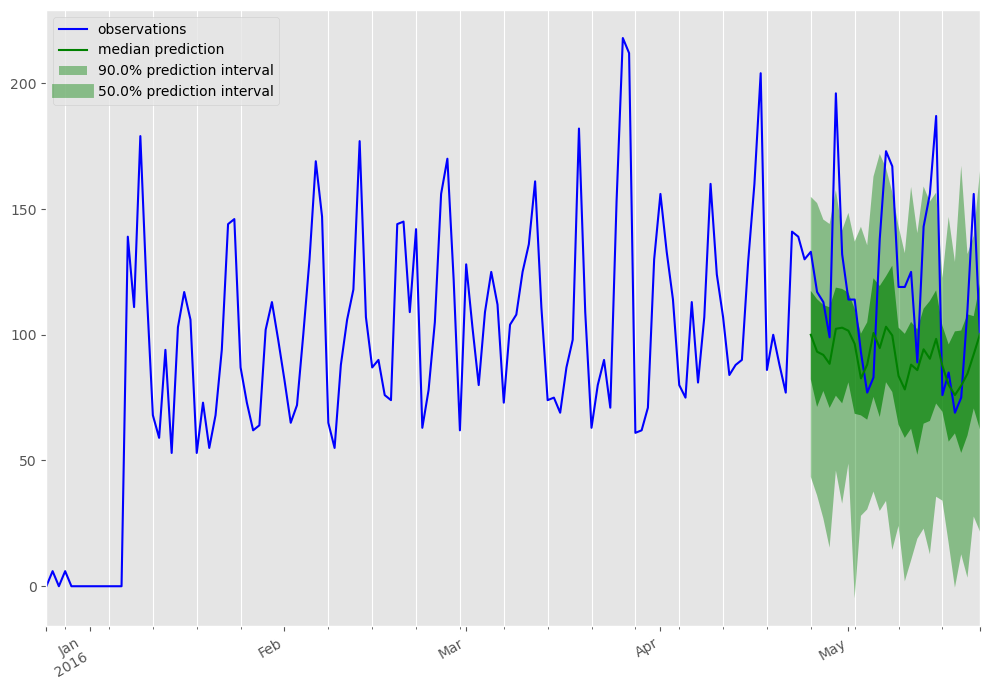

In [70]:
idx = indices[1]
plot_prob_forecasts(tss[idx], forecasts_deepar_naive[idx])

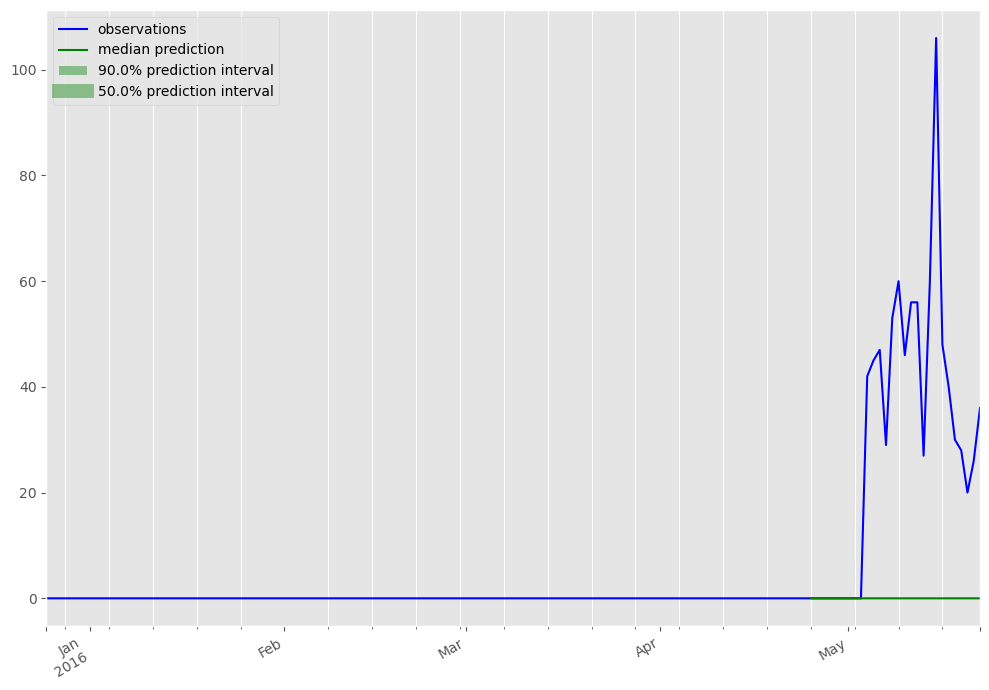

In [71]:
idx = indices[2]
plot_prob_forecasts(tss[idx], forecasts_deepar_naive[idx])

In [72]:
forecasts_deepar_naive[0].mean

array([-0.00182443, -0.00070774, -0.0013413 , -0.00156013, -0.0008047 ,
       -0.0006012 , -0.0004434 , -0.00054581, -0.00052644, -0.00060504,
       -0.00045797, -0.0003327 , -0.00044851, -0.00017877, -0.00029754,
       -0.00054157, -0.00035421, -0.00037533, -0.00017388, -0.00033243,
       -0.00013915, -0.0001441 , -0.00034233, -0.00044053, -0.00021232,
       -0.00039597, -0.00033675, -0.00025582], dtype=float32)

In [73]:
# best k (plot all non-trivial best forecasts)
indices = item_metrics_deepar_naive.nsmallest(1000, metric).index
ct = 0
to_plot = []
for idx in indices:
    # forecast mean (over all forecast periods) > 0.2 -> sparse forecast vector
    if (forecasts_deepar_naive[idx].mean.mean() > 0.2):
        to_plot.append([tss[idx], forecasts_deepar_naive[idx]])
        ct += 1
    if ct == k:
        break

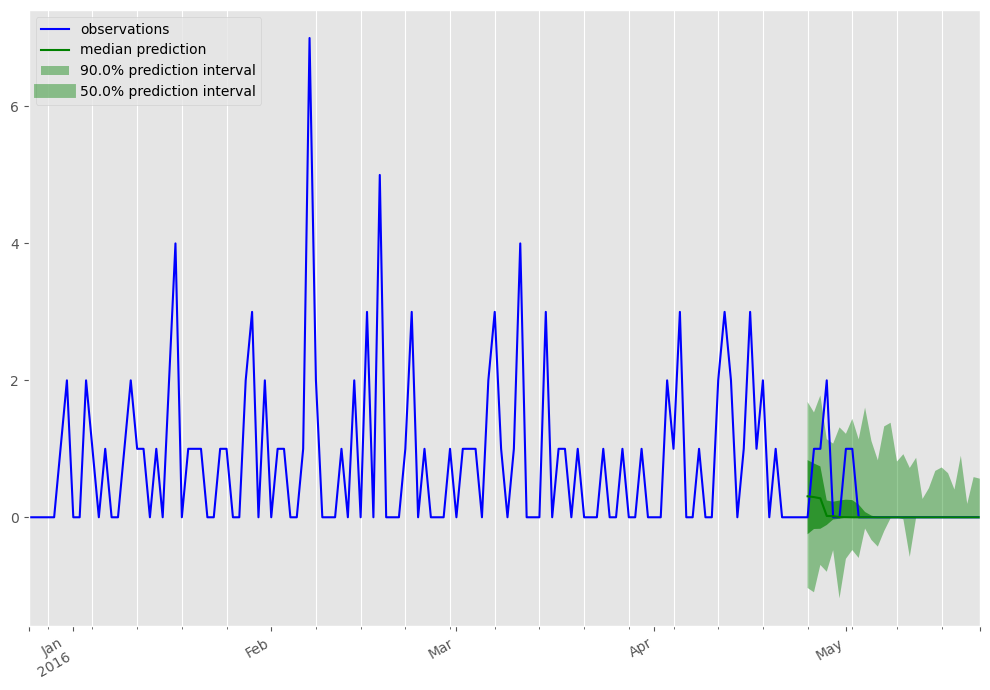

In [74]:
idx = 0
plot_prob_forecasts(to_plot[idx][0], to_plot[idx][1])

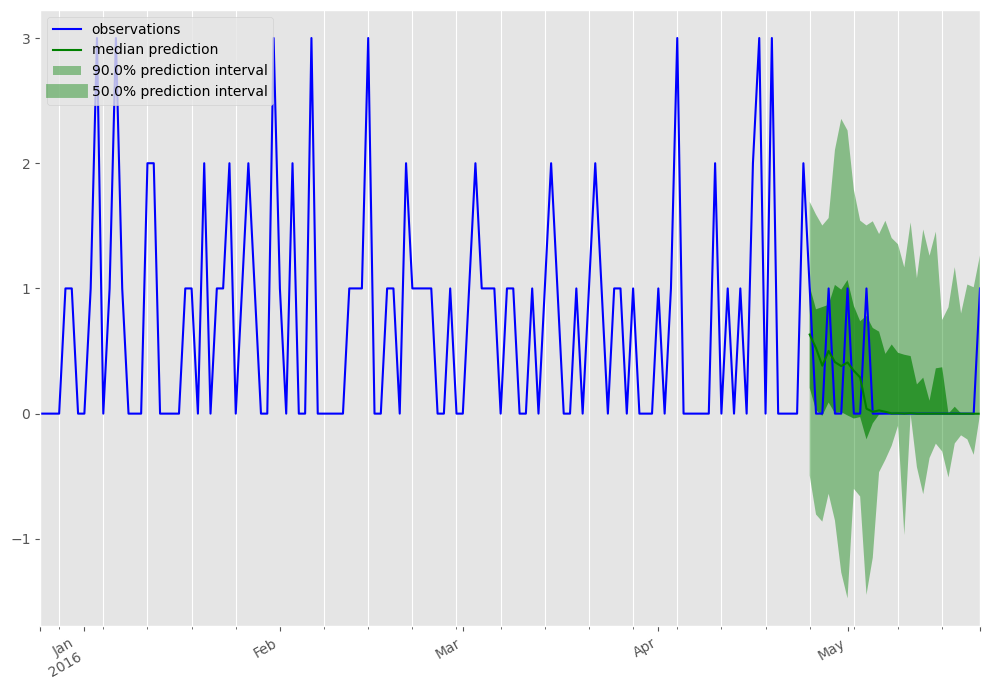

In [75]:
idx = 1
plot_prob_forecasts(to_plot[idx][0], to_plot[idx][1])

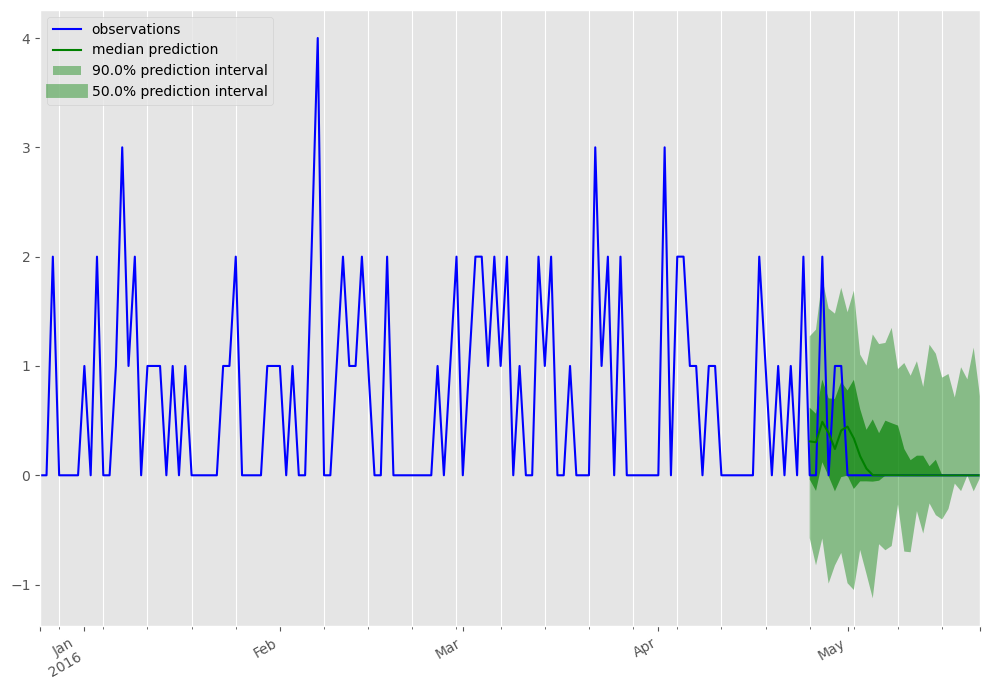

In [76]:
idx = 2
plot_prob_forecasts(to_plot[idx][0], to_plot[idx][1])

## Observations
* Forecasts can be negative
* Forecasts are real numbers, targets are counts

DeepAR by default uses a student-t distribution as output (more flexible than Gaussian, but still not adequate for count data).

Better choice: Negative Binomial Distribution.

In [77]:
from gluonts.torch.distributions import NegativeBinomialOutput, NormalOutput

In [78]:
estimator_deepar = DeepAREstimator(
    prediction_length=prediction_length,
    freq="1D",
    # adjust the output
    distr_output=NegativeBinomialOutput(),
    trainer_kwargs={
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "max_epochs": 500,
    },
    num_feat_dynamic_real=len(feat_dynamic_real),
    num_feat_static_cat=len(stat_cat_cardinalities),
    cardinality=stat_cat_cardinalities,
)
predictor_deepar = estimator_deepar.train(list(train_ds))

/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes                                                           | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARMod

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 1.66499 (best 1.66499), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 1.48213 (best 1.48213), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 1.42550 (best 1.42550), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_1/checkpoints/epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'train_loss' was not in top 1
Epoch 8, global step 450: 'train_loss' was not in top 1
Epoch 9, global step 500: 'train_

In [79]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor_deepar,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts_deepar = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


100%|██████████| 8230/8230 [00:00<00:00, 11218.69it/s]


Obtaining time series predictions ...


100%|██████████| 8230/8230 [02:34<00:00, 53.13it/s]


In [80]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
# gives me metrics both across time series and for individual time series
agg_metrics_deepar, item_metrics_deepar = evaluator(
    tss, forecasts_deepar)

print(json.dumps(agg_metrics_deepar, indent=4))

Running evaluation: 8230it [00:00, 18538.67it/s]


{
    "MSE": 9.197969020595052,
    "abs_error": 326934.0,
    "abs_target_sum": 564926.0,
    "abs_target_mean": 2.4515101544870683,
    "seasonal_error": 1.6637613497420738,
    "MASE": 0.9173395067750792,
    "MAPE": 0.6753078092478587,
    "sMAPE": 1.3116410768742188,
    "MSIS": 6.703147071150522,
    "QuantileLoss[0.1]": 100000.4,
    "Coverage[0.1]": 0.43689897587224436,
    "QuantileLoss[0.5]": 326934.0,
    "Coverage[0.5]": 0.6244271827807673,
    "QuantileLoss[0.9]": 208115.4,
    "Coverage[0.9]": 0.9174188508939419,
    "RMSE": 3.0328153621008735,
    "NRMSE": 1.2371212725959246,
    "ND": 0.5787200447492238,
    "wQuantileLoss[0.1]": 0.17701504267815607,
    "wQuantileLoss[0.5]": 0.5787200447492238,
    "wQuantileLoss[0.9]": 0.368394090553453,
    "mean_absolute_QuantileLoss": 211683.2666666667,
    "mean_wQuantileLoss": 0.37470972599361096,
    "MAE_Coverage": 0.417418850893942,
    "OWA": NaN
}


/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


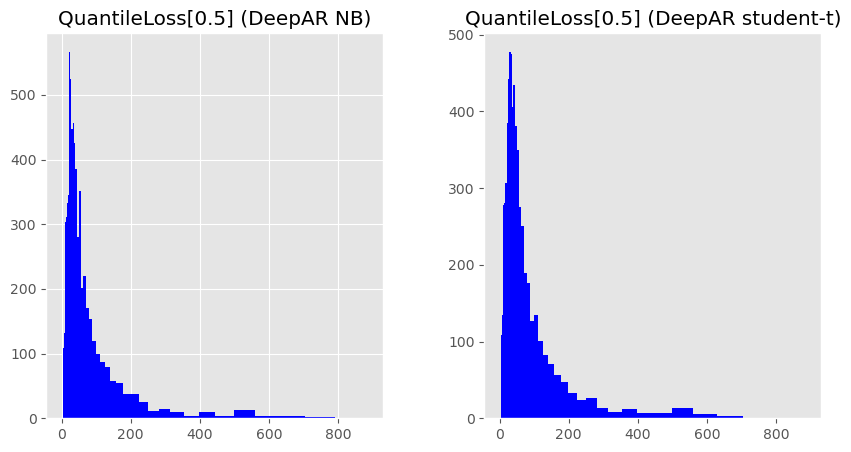

In [83]:
# obtain histogram of errors
metric='QuantileLoss[0.5]'
bins=np.append([0], np.logspace(np.log10(0.01),np.log10(item_metrics_deepar[metric].max()), 100))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
item_metrics_deepar.hist(column=metric, bins=bins, color="blue", ax=ax[0])
ax[0].set(title=f"{metric} (DeepAR NB)")
item_metrics_deepar_naive.hist(column=metric, bins=bins, color="blue", ax=ax[1])
ax[1].set(title=f"{metric} (DeepAR student-t)")
plt.grid(which="both")
plt.show()


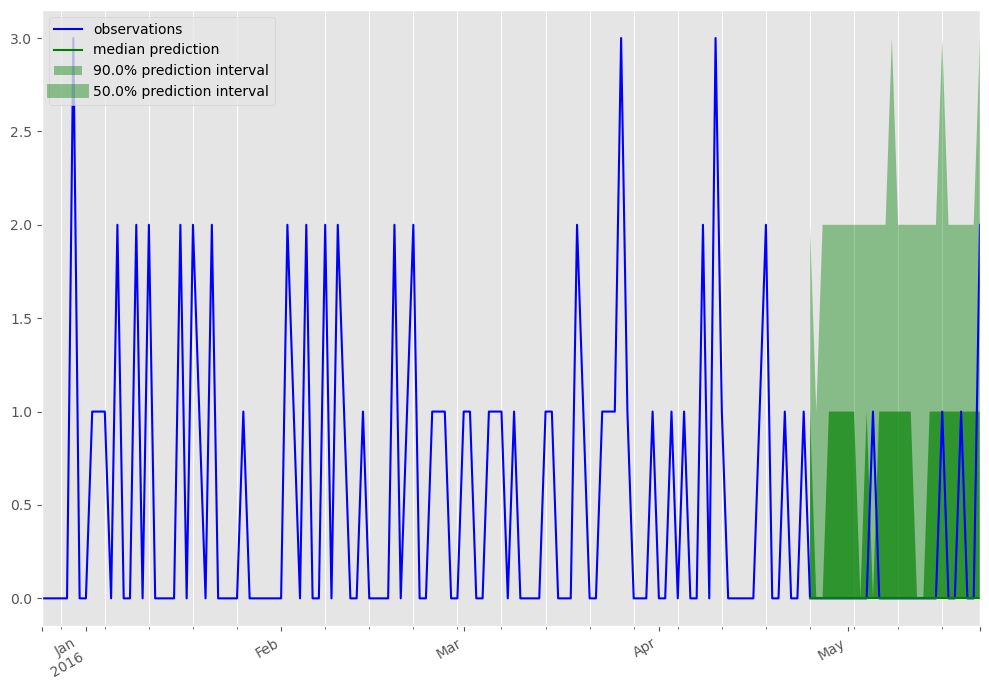

In [84]:
# check whether the forecasts look better, too
plot_prob_forecasts(tss[0], forecasts_deepar[0])

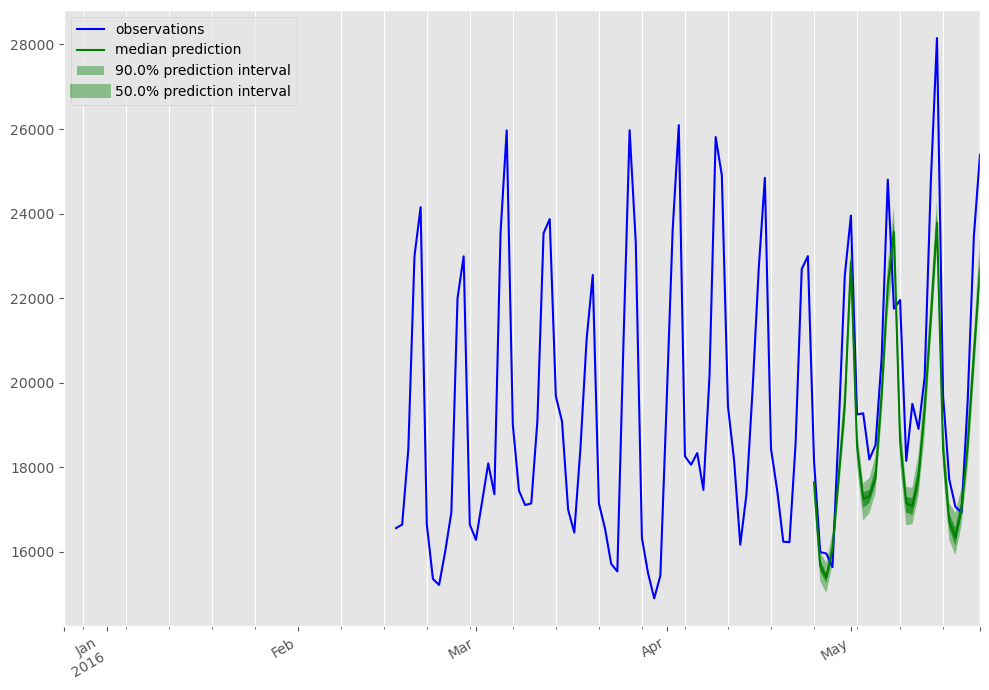

In [85]:
agg_prob_forecasts_deepar = reduce(lambda a, b: sum_forecasts(a, b), forecasts_deepar)

# plot the aggregated sales against the aggregated forecast
plot_prob_forecasts(agg_actuals, agg_prob_forecasts_deepar)

# Compare Evaluations across Methods

In [86]:
df_evaluations = pd.DataFrame.from_records(
    [agg_metrics_deepar_naive, agg_metrics_deepar,
     agg_metrics_npts],
    index=["DeepAR-student_t", "DeepAR", "NPTS"]
).transpose()

In [87]:
df_evaluations

,DeepAR-student_t,DeepAR,NPTS
MSE,11.159876,9.197969,11.459107
abs_error,351198.750618,326934.000000,366211.000000
abs_target_sum,564926.000000,564926.000000,564926.000000
abs_target_mean,2.451510,2.451510,2.451510
seasonal_error,1.663761,1.663761,1.663761
MASE,0.973587,0.917340,1.003146
MAPE,0.793206,0.675308,0.727814
sMAPE,1.512070,1.311641,1.365631
MSIS,15.978549,6.703147,9.817871
QuantileLoss[0.1],114199.993291,100000.400000,115812.600000


## Oversample important time series

One interesting technique is not to present all time series
in the training set as training example with equal probability, 
but to rather oversample "important" time series.

This can be achieve using the ``BucketInstanceSampler`` in DeepAR, 
but you could achieve something similar with standard pandas by 
duplication the more important time series.

In [88]:
from gluonts.dataset.stat import calculate_dataset_statistics
# allows to oversample important time series (important = numbers )
scale_histogram = calculate_dataset_statistics(train_ds).scale_histogram

100%|██████████| 8230/8230 [00:01<00:00, 5120.38it/s]


In [89]:
from gluonts.transform.sampler import BucketInstanceSampler

estimator_deepar_oversample = DeepAREstimator(
    prediction_length=prediction_length,
    freq="1D",
    # adjust the output
    distr_output=NegativeBinomialOutput(),
    # lags are determined automatically based on frequency
    #     lags_seq = [1],
    # scaling is automatically enabled
    # scaling = False,
    trainer_kwargs={
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "max_epochs": 100,
    },
    num_feat_dynamic_real=len(feat_dynamic_real), 
    num_feat_static_cat=len(stat_cat_cardinalities),
    cardinality = stat_cat_cardinalities,
    train_sampler=BucketInstanceSampler(scale_histogram=scale_histogram, min_future=prediction_length)
)
predictor_deepar_oversample = estimator_deepar_oversample.train(list(train_ds))

/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes                                                           | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARMod

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 19.47756 (best 19.47756), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.79569 (best 5.79569), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.04238 (best 3.04238), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 2.51893 (best 2.51893), saving model to '/home/studio-lab-user/TimeSeriesForecasting/notebooks/lightning_logs/version_2/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was n

In [90]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor_deepar_oversample,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts_deepar_oversample = list(tqdm(forecast_it, total=len(test_ds)))   

Obtaining time series conditioning values ...


100%|██████████| 8230/8230 [00:01<00:00, 4570.32it/s] 


Obtaining time series predictions ...


100%|██████████| 8230/8230 [02:30<00:00, 54.65it/s]


In [91]:
type(forecasts_deepar_oversample[0])

gluonts.model.forecast.SampleForecast

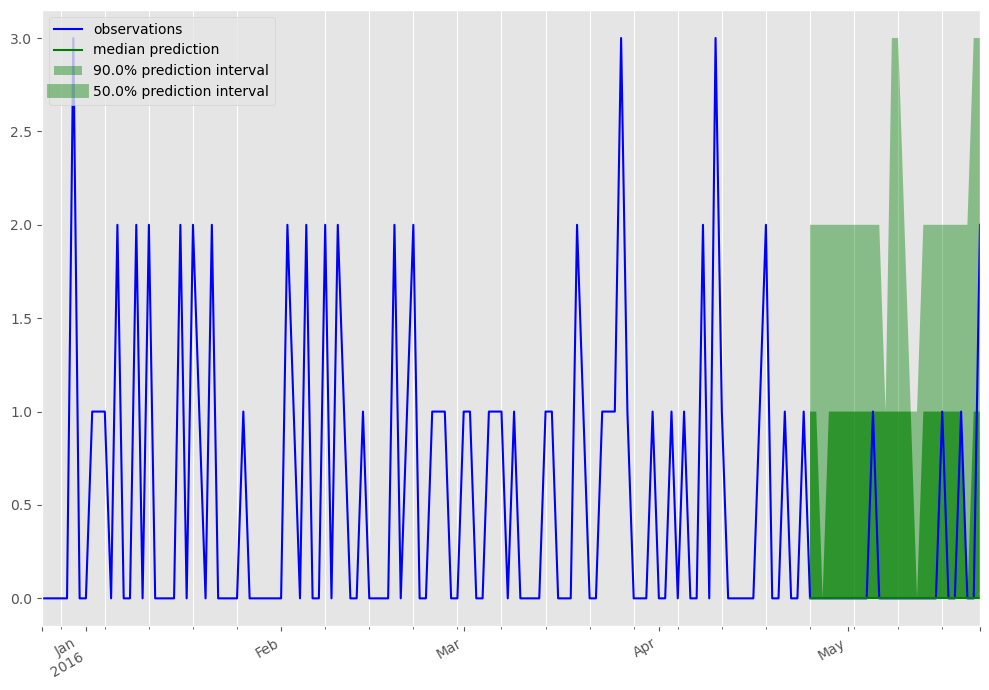

In [92]:
plt_idx = 0
plot_prob_forecasts(tss[plt_idx], forecasts_deepar_oversample[plt_idx])

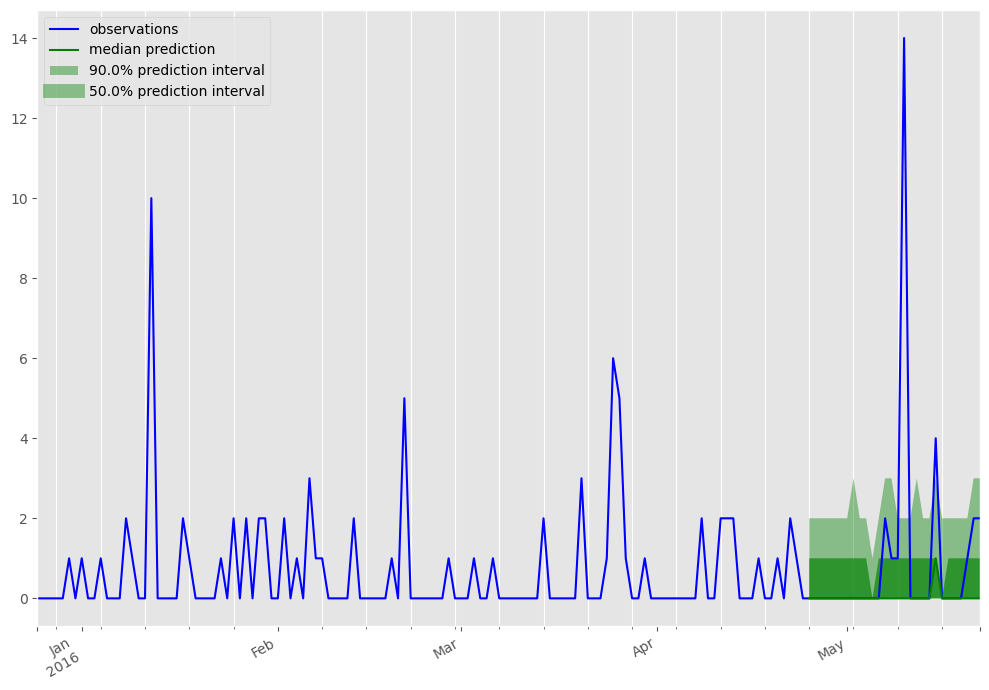

In [93]:
plt_idx = 1
plot_prob_forecasts(tss[plt_idx], forecasts_deepar_oversample[plt_idx])

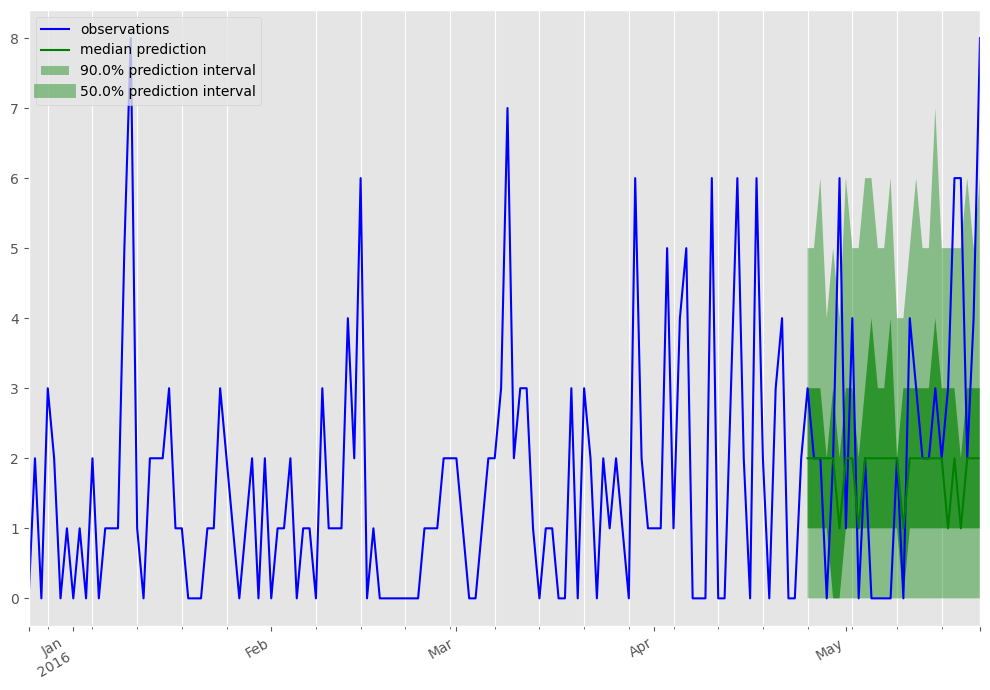

In [94]:
plt_idx = 2
plot_prob_forecasts(tss[plt_idx], forecasts_deepar_oversample[plt_idx])

In [95]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_deepar_oversample, item_metrics_deepar_oversample = evaluator(tss, forecasts_deepar_oversample)
agg_metrics_deepar_oversample

Running evaluation: 8230it [00:00, 14466.02it/s]
/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


{'MSE': 11.60293011445529,
 'abs_error': 329899.0,
 'abs_target_sum': 564926.0,
 'abs_target_mean': 2.4515101544870683,
 'seasonal_error': 1.6637613497420738,
 'MASE': 0.9219776327652364,
 'MAPE': 0.6787147306863653,
 'sMAPE': 1.298999960756937,
 'MSIS': 6.952880651617423,
 'QuantileLoss[0.1]': 100132.6,
 'Coverage[0.1]': 0.4445972921367818,
 'QuantileLoss[0.5]': 329899.0,
 'Coverage[0.5]': 0.6440591911126541,
 'QuantileLoss[0.9]': 214124.59999999998,
 'Coverage[0.9]': 0.9144159000173581,
 'RMSE': 3.4063074016382155,
 'NRMSE': 1.3894730949425418,
 'ND': 0.583968519770731,
 'wQuantileLoss[0.1]': 0.1772490556285248,
 'wQuantileLoss[0.5]': 0.583968519770731,
 'wQuantileLoss[0.9]': 0.3790312359494871,
 'mean_absolute_QuantileLoss': 214718.7333333333,
 'mean_wQuantileLoss': 0.3800829371162477,
 'MAE_Coverage': 0.4144159000173581,
 'OWA': nan}

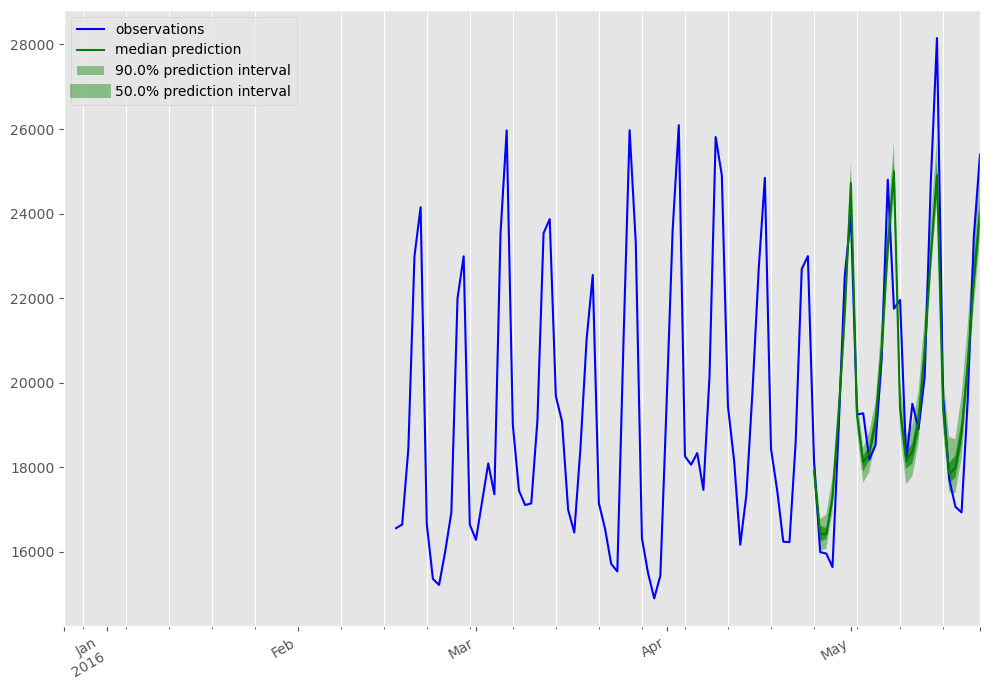

In [96]:
agg_actuals = sum(tss)
agg_prob_forecasts = reduce(lambda a, b: sum_forecasts(a, b), forecasts_deepar_oversample)

# plot the aggregated sales against the aggregated forecast
plot_prob_forecasts(agg_actuals, agg_prob_forecasts)

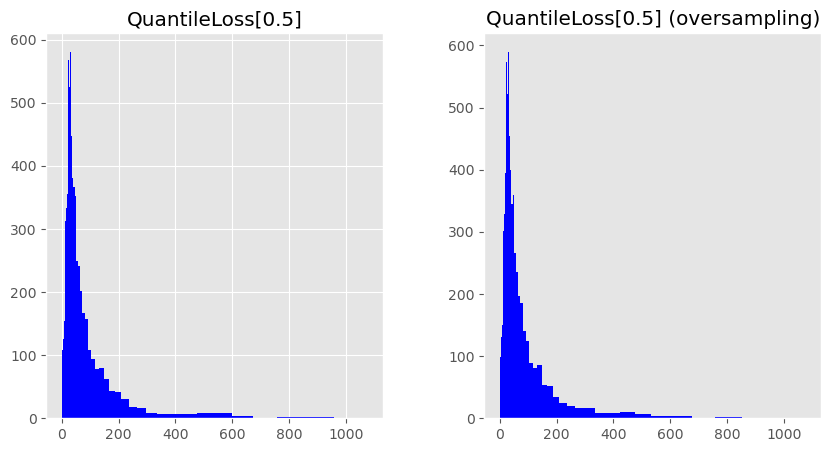

In [100]:
# obtain histogram of errors
metric='QuantileLoss[0.5]'
bins=np.append([0], np.logspace(np.log10(0.01),np.log10(item_metrics_deepar_oversample[metric].max()), 100))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
item_metrics_deepar.hist(column=metric, bins=bins, color="blue", ax=ax[0])
ax[0].set_title(metric)
item_metrics_deepar_oversample.hist(column=metric, bins=bins, color="blue", ax=ax[1])
ax[1].set_title(f"{metric} (oversampling)")
plt.grid(which="both")
plt.show()

# Hyper-parameter tuning

For best accuracy, deep learning models often require tuning of their hyper-parameters. These can include architectural details (number of layers, size of layers, activations being used, normalization), or training options (dropout rate, optimization algorithm to use, early stopping).

There are several packages offering hyper-parameter tuning functionality, that GluonTS can easily work with. Let's look at an example using Optuna.

In [101]:
import optuna

The way this works is simple: we need to define an "objective" to be optimized. This objective maps a given configuration of hyper-parameters into an objective value (usually some accuracy metric on a validation set).

The following class does exactly this. In the `__call__` method:
1. the hyper-parameters values to evaluate are retrieved
2. a DeepAREstimator is constructed with such hyper-parameters values
3. the estimator is trained on a training subset of the data
4. the resulting model is evaluated on a validation subset of the data, and some metric of choice is returned

In [102]:
class DeepARTuningObjective:
    def __init__(self, dataset, prediction_length: int, freq: str):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq

        entry_split = [self.split_entry(entry) for entry in self.dataset]
        self.entry_pasts = [entry[0] for entry in entry_split]
        self.entry_futures = [entry[1] for entry in entry_split]

    def __call__(self, trial):
        params = self.get_params(trial)

        estimator = DeepAREstimator(
            num_layers=params['num_layers'],
            hidden_size=params['hidden_size'],
            prediction_length=self.prediction_length,
            freq=self.freq,
            trainer_kwargs={
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "max_epochs": 10,
            }
        )

        predictor = estimator.train(self.entry_pasts, cache_data=True)
        forecast_it = predictor.predict(self.entry_pasts)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(self.entry_futures, forecasts, num_series=len(self.dataset))
        return agg_metrics["mean_wQuantileLoss"]

    def get_params(self, trial: optuna.trial.Trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
        }

    def split_entry(self, entry):
        entry_past = {}
        for key, value in entry.items():
            if key == "target":
                entry_past[key] = value[: -self.prediction_length]
            else:
                entry_past[key] = value

        df = pd.DataFrame(
            entry['target'],
            index=pd.period_range(
                start=entry['start'],
                periods=len(entry['target']),
                freq=self.freq
            )
        )

        return entry_past, df[-self.prediction_length:]

Optuna will take care of picking the next hyper-parameter settings to try, based on past values of the validation metric.

This will result in a sequence of training procedures being run, one for each hyper-parameter setting.

In [104]:
objective = DeepARTuningObjective(train_ds, freq="1D", prediction_length=6 * 12)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)